In [1]:
%%bash
dx download -f /jc_notebook/MHC_37.fa

In [2]:
%%capture
%%bash
dx download -f /jc_notebook/peregrine0.1.5asm.tgz
tar zxvf peregrine0.1.5asm.tgz

In [3]:
%%capture
%%bash
. /opt/conda/bin/activate
conda install -y matplotlib bokeh

In [4]:
%%bash
rm -rf Peregrine
git clone https://github.com/cschin/Peregrine.git


Cloning into 'Peregrine'...


In [5]:
%%capture
%%bash
apt-get install -y zlib1g-dev
. /opt/conda/bin/activate
conda install -c conda-forge -y pypy3.6
cd Peregrine
pushd py
rm -rf .eggs/ dist/ build/ peregrine.egg-info/ peregrine_pypy.egg-info get-pip.py
python3 setup.py install
python3 setup.py clean --all
popd
git clone -b peregrine https://github.com/cschin/pypeFLOW.git
pushd pypeFLOW
python3 setup.py install
popd
pushd py
wget -q https://bootstrap.pypa.io/get-pip.py
pypy3 get-pip.py
pypy3 setup_pypy.py install
popd

pushd src
make all
make install
popd


In [6]:
import peregrine
import sys, os
from peregrine._falcon4py import ffi as falcon_ffi
from peregrine._falcon4py import lib as falcon4py
from peregrine._shimmer4py import ffi as shimmer_ffi
from peregrine._shimmer4py import lib as shimmer4py
import numpy as np
import mmap
from pprint import pprint

Peregrine Assembler & SHIMMER ASMKit(0.1.5.3)


In [7]:
import peregrine.utils
mmer2tuple = peregrine.utils.mmer2tuple

In [8]:
%%writefile match.sh
echo $1 > seq1.lst
echo $2 > seq2.lst
shmr_mkseqdb -d seq1.lst -p seq1
shmr_mkseqdb -d seq2.lst -p seq2
shmr_index -p seq1 -o seq1-shmr
shmr_index -p seq2 -o seq2-shmr
shmr_map -r seq1 -m seq1-shmr-L2 -p seq2 -l seq2-shmr-L2 > seq1-seq2-map

Overwriting match.sh


In [9]:
%%time
!cat peregrine0.1.5asm/H1/asm.pg0.1.5.0/4-cns/cns-merge/p_ctg_cns.fa > p_ctg_cns.fa
!cat peregrine0.1.5asm/H2/asm.pg0.1.5.0/4-cns/cns-merge/p_ctg_cns.fa >> p_ctg_cns.fa
!bash match.sh MHC_37.fa p_ctg_cns.fa

input sequence dataset file list: 'seq1.lst'
output index file: seq1.idx
output seqdb file: seq1.idx
input sequence dataset file list: 'seq2.lst'
output index file: seq2.idx
output seqdb file: seq2.idx
reduction factor= 6
using index file: seq1.idx
using seqdb file: seq1.seqdb
output data file: seq1-shmr-L0-01-of-01.dat
output data file: seq1-shmr-L0-MC-01-of-01.dat
output data file: seq1-shmr-L2-01-of-01.dat
output data file: seq1-shmr-L2-MC-01-of-01.dat
reduction factor= 6
using index file: seq2.idx
using seqdb file: seq2.seqdb
output data file: seq2-shmr-L0-01-of-01.dat
output data file: seq2-shmr-L0-MC-01-of-01.dat
output data file: seq2-shmr-L2-01-of-01.dat
output data file: seq2-shmr-L2-MC-01-of-01.dat
using ref index file: seq1.idx
using ref seqdb file: seq1.seqdb
using ref shimmer data file: seq1-shmr-L2-01-of-01.dat
number of shimmers load: 12642
using index file: seq2.idx
using seqdb file: seq2.seqdb
using shimmer data file: seq2-shmr-L2-01-of-01.dat
number of shimmers load: 

In [10]:
!ls

GRCh38-MHC.fa		      seq1-shmr-L2-MC-01-of-01.dat
MHC_37.fa		      seq1.idx
Peregrine		      seq1.lst
ids1			      seq1.seqdb
ids2			      seq2-shmr-L0-01-of-01.dat
match.sh		      seq2-shmr-L0-MC-01-of-01.dat
p_ctg_cns.fa		      seq2-shmr-L2-01-of-01.dat
peregrine0.1.5asm	      seq2-shmr-L2-MC-01-of-01.dat
peregrine0.1.5asm.tgz	      seq2.idx
pgp1-MHC.fa		      seq2.lst
seq1-seq2-map		      seq2.seqdb
seq1-shmr-L0-01-of-01.dat     unphased_reads_on_assembly.fa
seq1-shmr-L0-MC-01-of-01.dat  unphased_reads_on_assembly_ids
seq1-shmr-L2-01-of-01.dat


MHC on GRC37: chr6:28,477,797-33,448,354

In [11]:
ref_data = {}
name2rid = {}
with open("seq1.idx") as f:
    for row in f:
        row = row.strip().split()
        rid, rname, rlen, offset = row
        rid = int(rid)
        rlen = int(rlen)
        offset = int(offset)
        ref_data.setdefault(rid, {})
        name2rid[rname] = rid
        ref_data[rid]["name"] = rname
        ref_data[rid]["length"] = rlen
        ref_data[rid]["offset"] = offset

asm_data = {}

with open("seq2.idx") as f:
    for row in f:
        row = row.strip().split()
        rid, rname, rlen, offset = row
        rid = int(rid)
        rlen = int(rlen)
        offset = int(offset)
        asm_data.setdefault(rid, {})
        asm_data[rid]["name"] = rname
        asm_data[rid]["length"] = rlen
        asm_data[rid]["offset"] = offset
        


In [12]:
chr6_rid = name2rid["6:28477798-33448354"]
print("id for chr6:", chr6_rid)
hits = {}
hit_keys = []
with open("seq1-seq2-map") as f:
    for row in f:
        row = [int(c) for c in row.strip().split()]
        if row[0] == chr6_rid and row[1] >= 0 and row[2] <= 4970556:
            hits.setdefault( (row[3], row[6]), [] )
            hits[(row[3], row[6])].append(row)

id for chr6: 0


In [13]:
hits_count = [(k, len(v)) for k, v in hits.items()]
hits_count.sort(key=lambda x: -x[1])
pprint(hits_count[:15])

[((22, 0), 7985),
 ((9, 0), 7868),
 ((22, 1), 111),
 ((9, 1), 103),
 ((23, 0), 30),
 ((24, 1), 24),
 ((2, 1), 19),
 ((13, 1), 15),
 ((5, 1), 15),
 ((18, 1), 15),
 ((25, 0), 8),
 ((12, 1), 7),
 ((21, 1), 7),
 ((11, 0), 7),
 ((13, 0), 5)]


In [14]:
aligned = []
h1_idx = [1]
for idx in h1_idx:
    k, v = hits_count[idx]
    hits2 = hits[k]
    hits2.sort(key=lambda x:x[4])
    s = hits2[0]
    e = hits2[-1]
    print(e[2] - s[1])
    print(e[5] - s[4])
    aligned.append( (k[0], k[1], s[4], e[5]) )
    print(asm_data[k[0]])
pprint(aligned)

aligned2 = []
h2_idx = [0]
for idx in h2_idx:
    k, v = hits_count[idx]
    hits2 = hits[k]
    hits2.sort(key=lambda x:x[4])
    s = hits2[0]
    e = hits2[-1]
    print(e[2] - s[1])
    print(e[5] - s[4])
    aligned2.append( (k[0], k[1], s[4], e[5]) )
    print(asm_data[k[0]])
pprint(aligned2)


2579776
5016728
{'name': '000000F', 'length': 5036767, 'offset': 230232}
[(9, 0, 14086, 5030814)]
2579776
4922645
{'name': '000000F', 'length': 4944350, 'offset': 5699845}
[(22, 0, 14086, 4936731)]


In [15]:
f=open("seq2.seqdb", "rb")
seqdb=mmap.mmap(f.fileno(), 0, flags=mmap.MAP_SHARED, prot=mmap.PROT_READ)

In [16]:
rmap = dict(zip(b"ACGT", b"TGCA"))

In [17]:
f1 = open("seq1.seqdb", "rb")
seqdb1 =mmap.mmap(f1.fileno(), 0, flags=mmap.MAP_SHARED, prot=mmap.PROT_READ)

f2 = open("seq2.seqdb", "rb")
seqdb2 =mmap.mmap(f2.fileno(), 0, flags=mmap.MAP_SHARED, prot=mmap.PROT_READ)

In [18]:
basemap = {1:"A",2:"C",4:"G",8:"T"}
with open("GRCh38-MHC.fa","w") as f:
    s0 = ref_data[0]['offset']
    e0 = s0 + ref_data[0]['length']
    s = s0+0
    e = s0+4970556
    seq =  "".join([basemap[c&0x0F] for c in seqdb1[s:e]])
    print(">GRCh38:chr6:28510120-33480577", file=f)
    print(seq, file=f)
    
with open("pgp1-MHC.fa","w") as f:
    for rid, direction, start, end in aligned:
        s0 = asm_data[rid]['offset']
        e0 = s0 + asm_data[rid]['length']
        s = s0 + start
        e = s0 + end
        if direction == 1:
            seq =  "".join([basemap[(c&0xF0)>>4] for c in seqdb2[s:e]])
        else:
            seq =  "".join([basemap[(c&0x0F)] for c in seqdb2[s:e]])
        print(f">{rid}-{direction}:{start}-{end}", file=f)
        print(seq, file=f)

In [19]:
import peregrine.utils

r = 12

basemap = {1:b"A",2:b"C",4:b"G",8:b"T"}
all_shmrs = []
mmers = []
s0 = ref_data[0]['offset']
e0 = s0 + ref_data[0]['length']
s = s0+0
e = s0+4970556
seq =  b"".join([basemap[c&0x0F] for c in seqdb1[s:e]])
base_shmrs = peregrine.utils.get_shimmers_from_seq(seq, rid=rid, reduction_factor=r)

all_shmr_alns = []    
for rid, direction, start, end in aligned:
    s0 = asm_data[rid]['offset']
    e0 = s0 + asm_data[rid]['length']
    s = s0 + start
    e = s0 + end
    if direction == 1:
        seq =  b"".join([basemap[(c&0xF0)>>4] for c in seqdb2[s:e]])
    else:
        seq =  b"".join([basemap[(c&0x0F)] for c in seqdb2[s:e]])
    shmrs = peregrine.utils.get_shimmers_from_seq(seq, rid=rid, reduction_factor=r)
    aln = shimmer4py.shmr_aln(base_shmrs, shmrs, 0, 1000, 15000, 1 ) 
    all_shmr_alns.append( (rid, shmrs, aln) )
    
    
all_shmr_alns2 = []    
for rid, direction, start, end in aligned2:
    s0 = asm_data[rid]['offset']
    e0 = s0 + asm_data[rid]['length']
    s = s0 + start
    e = s0 + end
    if direction == 1:
        seq =  b"".join([basemap[(c&0xF0)>>4] for c in seqdb2[s:e]])
    else:
        seq =  b"".join([basemap[(c&0x0F)] for c in seqdb2[s:e]])
    shmrs = peregrine.utils.get_shimmers_from_seq(seq, rid=rid, reduction_factor=r)
    aln = shimmer4py.shmr_aln(base_shmrs, shmrs, 0, 1000, 15000, 1 ) 
    all_shmr_alns2.append( (rid, shmrs, aln) )

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [37]:
# Standard imports 

from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models import HoverTool

Loading BokehJS ...

In [22]:
x = []
y = []
base_mmer_x = {}
for i in range(base_shmrs.n):
    m = mmer2tuple(base_shmrs.a[i])
    m, pos = m[0], m[3]
    base_mmer_x.setdefault(m, [])
    base_mmer_x[m].append(pos)
y_offset = 0
for rid, shmrs, aln in all_shmr_alns:
    max_y = 0
    for i in range(shmrs.n):
        m = mmer2tuple(shmrs.a[i])
        m, pos = m[0], m[3]
        if m in base_mmer_x:
            for p in base_mmer_x[m]:
                x.append(p)
                y.append(pos + y_offset)
                if pos > max_y:
                    max_y = pos
    y_offset += max_y 

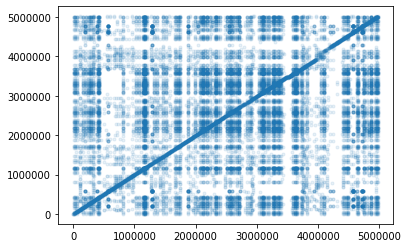

In [23]:
plt.plot(x, y , ".", alpha = 0.1)

In [24]:
if r >= 12: # too many point for a browser to handle if the shimmers are too dense
    p = figure(plot_width=600, plot_height=400, 
               x_axis_label="MHC_GRCh37",
               y_axis_label="contig")

    p.circle(x, y, fill_color="white", size=1, alpha=0.5)
    #p.add_tools(HoverTool())
    show(p)

In [25]:
x = []
y = []
y_offset = 0

for rid, shmrs, aln in all_shmr_alns:
    for aln_i in range(aln.n):
        if aln.a[aln_i].idx0.n < 5:
            continue   
        print(rid, asm_data[rid]["name"], aln_i, aln.a[aln_i].idx0.n)
        for i in range(aln.a[aln_i].idx0.n):
            idx0, idx1 = aln.a[aln_i].idx0.a[i], aln.a[aln_i].idx1.a[i]
            mmer0 = mmer2tuple(base_shmrs.a[idx0])
            mmer1 = mmer2tuple(shmrs.a[idx1])
            x.append(mmer0[3])
            y.append(mmer1[3] + y_offset)
    y_offset += mmer1[3]

9 000000F 0 106
9 000000F 1 579
9 000000F 4 11
9 000000F 5 270
9 000000F 7 286
9 000000F 10 80
9 000000F 12 25
9 000000F 15 33
9 000000F 19 11
9 000000F 20 267
9 000000F 22 212
9 000000F 28 5
9 000000F 39 13
9 000000F 42 429


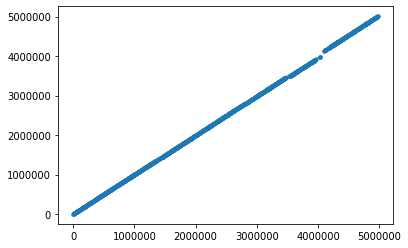

In [26]:
plt.plot(x,y,".")

In [27]:
x_seg = []
y_seg = []
x = []
y = []
aln_seg= []
y_offset = 0
for rid, shmrs, aln in all_shmr_alns:
    for aln_i in range(aln.n):
        n = aln.a[aln_i].idx0.n 
        if n < 5:
            continue

        idx0s, idx0e = aln.a[aln_i].idx0.a[0], aln.a[aln_i].idx0.a[n-1]
        idx1s, idx1e = aln.a[aln_i].idx1.a[0], aln.a[aln_i].idx1.a[n-1]

        m0s = mmer2tuple(base_shmrs.a[idx0s])
        m0e = mmer2tuple(base_shmrs.a[idx0e])
        m1s = mmer2tuple(shmrs.a[idx1s])
        m1e = mmer2tuple(shmrs.a[idx1e])
        x_seg.append( (m0s[3],m0e[3]) )
        y_seg.append( (m1s[3] + y_offset, m1e[3] + y_offset) )
        x.extend( [m0s[3], m0e[3]] )
        y.extend( [m1s[3] + + y_offset, m1e[3] + + y_offset] )
        aln_seg.append(  ((m0s[3], m0e[3]), (m1s[3], m1e[3]), n))
    y_offset += m1e[3]
    # print(y_offset)
    
aln_seg.sort()  
# aln_seg

In [28]:
x_seg[:1], y_seg[:1]

([(2707, 202369)], [(2596, 202195)])

In [29]:
# create a new plot with default tools, using figure
p = figure(plot_width=600, plot_height=400, 
           x_axis_label="MHC_GRCh37",
           y_axis_label="contig")
p.multi_line(x_seg, y_seg, line_width=2)
p.circle(x, y, fill_color="white", size=4)
p.add_tools(HoverTool())
show(p)

In [30]:
r = 12

basemap = {1:b"A",2:b"C",4:b"G",8:b"T"}
all_shmrs = []
mmers = []
s0 = ref_data[0]['offset']
e0 = s0 + ref_data[0]['length']
s = s0+0
e = s0+4970556
seq =  b"".join([basemap[c&0x0F] for c in seqdb1[s:e]])
base_shmrs = peregrine.utils.get_shimmers_from_seq(seq, rid=rid, reduction_factor=r)
ref_seq = seq[:]
all_shmr_alns = []
rid2seq = {}
for rid, direction, start, end in aligned:
    s0 = asm_data[rid]['offset']
    e0 = s0 + asm_data[rid]['length']
    s = s0 + start
    e = s0 + end
    if direction == 1:
        seq =  b"".join([basemap[(c&0xF0)>>4] for c in seqdb2[s:e]])
    else:
        seq =  b"".join([basemap[(c&0x0F)] for c in seqdb2[s:e]])
    shmrs = peregrine.utils.get_shimmers_from_seq(seq, rid=rid, reduction_factor=r)
    aln = shimmer4py.shmr_aln(base_shmrs, shmrs, 0, 1000, 15000, 1 ) 
    all_shmr_alns.append( (rid, shmrs, aln) )
    rid2seq[rid] = seq

all_shmr_alns2 = []
for rid, direction, start, end in aligned2:
    s0 = asm_data[rid]['offset']
    e0 = s0 + asm_data[rid]['length']
    s = s0 + start
    e = s0 + end
    if direction == 1:
        seq =  b"".join([basemap[(c&0xF0)>>4] for c in seqdb2[s:e]])
    else:
        seq =  b"".join([basemap[(c&0x0F)] for c in seqdb2[s:e]])
    shmrs = peregrine.utils.get_shimmers_from_seq(seq, rid=rid, reduction_factor=r)
    aln = shimmer4py.shmr_aln(base_shmrs, shmrs, 0, 1000, 15000, 1 ) 
    all_shmr_alns2.append( (rid, shmrs, aln) )
    rid2seq[rid] = seq

In [31]:

from peregrine._falcon4py import lib as falcon
from peregrine._falcon4py import ffi

In [32]:
from bokeh import palettes as bp
inferno10=bp.inferno(11)
inferno10.reverse()

In [33]:
patches_x = []
patches_y = []
colors = []
x_offset = 0
x_start = None
ctg_range = {}
for rid, shmrs, aln in all_shmr_alns:
    ctg_range[rid] = [0, 0]
    for aln_i in range(aln.n):

        n = aln.a[aln_i].idx0.n
        
        if n < 5:
            continue
        for i in range(n-1):

            idx0 = aln.a[aln_i].idx0.a[i]
            idx1 = aln.a[aln_i].idx1.a[i]
            m00 = mmer2tuple(base_shmrs.a[idx0])
            m10 = mmer2tuple(shmrs.a[idx1])

            idx0 = aln.a[aln_i].idx0.a[i+1]
            idx1 = aln.a[aln_i].idx1.a[i+1]
            m01 = mmer2tuple(base_shmrs.a[idx0])
            m11 = mmer2tuple(shmrs.a[idx1])
            
            if x_start == None:
                x_offset = -m10[3]
                x_start = x_offset
            
            seq0  =  ref_seq[m00[3]:m01[3]]
            asm_seq = rid2seq[rid][m10[3]:m11[3]]
            
            estimate_err = 100
            seq_aln = falcon.align(seq0, len(seq0), asm_seq,  len(asm_seq), 500, 1)
            if seq_aln.aln_str_size > 0:
                estimate_err = 100.0 * seq_aln.dist / seq_aln.aln_str_size
            estimate_err = int(estimate_err*2)
            if estimate_err > 10:
                estimate_err = 10
            #estimate_err = 2
            patches_x.append( (m00[3],  m01[3], m11[3] + x_offset, m10[3] + x_offset) )
            patches_y.append( (0, 0, 1, 1) )        
            if i == 0 and aln_i == 0:
                ctg_range[rid][0] = m10[3] + x_offset
            if i == n-2:
                ctg_range[rid][1] = m11[3] + x_offset
            #print(i, aln_i, m11[3] + x_offset)
            colors.append( inferno10[estimate_err])
    x_offset =  m10[3] + x_start + 50000
    
    
x_offset = 0
x_start = None
ctg_range2 = {}
for rid, shmrs, aln in all_shmr_alns2:
    ctg_range2[rid] = [0, 0]
    for aln_i in range(aln.n):

        n = aln.a[aln_i].idx0.n
        
        if n < 5:
            continue
        for i in range(n-1):

            idx0 = aln.a[aln_i].idx0.a[i]
            idx1 = aln.a[aln_i].idx1.a[i]
            m00 = mmer2tuple(base_shmrs.a[idx0])
            m10 = mmer2tuple(shmrs.a[idx1])

            idx0 = aln.a[aln_i].idx0.a[i+1]
            idx1 = aln.a[aln_i].idx1.a[i+1]
            m01 = mmer2tuple(base_shmrs.a[idx0])
            m11 = mmer2tuple(shmrs.a[idx1])
            
            if x_start == None:
                x_offset = -m10[3]
                x_start = x_offset
            
            seq0  =  ref_seq[m00[3]:m01[3]]
            asm_seq = rid2seq[rid][m10[3]:m11[3]]
            
            estimate_err = 100
            seq_aln = falcon.align(seq0, len(seq0), asm_seq,  len(asm_seq), 500, 1)
            if seq_aln.aln_str_size > 0:
                estimate_err = 100.0 * seq_aln.dist / seq_aln.aln_str_size
            estimate_err = int(estimate_err*2)
            if estimate_err > 10:
                estimate_err = 10
            #estimate_err = 2
            patches_x.append( (m00[3],  m01[3], m11[3] + x_offset, m10[3] + x_offset) )
            patches_y.append( (0, 0, -1, -1) )        
            if i == 0 and aln_i == 0:
                ctg_range2[rid][0] = m10[3] + x_offset
            if i == n-2:
                ctg_range2[rid][1] = m11[3] + x_offset
            #print(i, aln_i, m11[3] + x_offset)
            colors.append( inferno10[estimate_err])
    x_offset =  m10[3] + x_start + 50000

In [34]:
ctg_range, ctg_range2

({9: [0, 5006701]}, {22: [0, 4912591]})

In [40]:
HLA_loci = {"HLA-A":29910309,
            "HLA-B":31321643,
            "HLA-C":31236526,
            "HLA-DOA":32971960,
           "HLA-DPA1": 33032346,
           "HLA-DQA1":32605183,
           "HLA-DRA":32407664,
           "HLA-DRB1":32546546,
           "HLA-DQB1":32627245,
           "CYP21A2,TNXB":31973359,
           }

H1_LC = [(2241502, 2241602),
(2389551, 2389651),
(3475198, 3475399),
(3486442, 3508043),
(3956145, 3969225)]

H2_LC = [(2085306, 2085406),
(2244234, 2244334),
(2392104, 2392204),
(3473257, 3473557),
(3486094, 3506188),
(3951022, 3970406)]

In [53]:
MHC_s = 28477797
MHC_e = 28477797 + 4970556

p = figure(plot_width=1200, plot_height=360, 
           x_axis_label="GRCh37 MHC Chr6:28477797-33448354",
           y_axis_label="contig")
p.patches(patches_x, patches_y, line_width=0.02, line_color="#000000", fill_color=colors, alpha=0.7)
i = 0
p.line([0,MHC_e-MHC_s],[0,0], line_width=5, color=bp.Category10[5][i%5])
i +=1
for k, v in ctg_range.items():
    s, e = v
    p.line([s,e],[1,1], line_width=5, color=bp.Category10[5][i])
   
    i += 1
    
for s, e in H1_LC:
    p.line([s,e],[1,1], line_width=5, color="black")
    p.square( x=s, y=1.05, color="grey", size=5 )
      
    
for k, v in ctg_range2.items():
    s, e = v
    p.line([s,e],[-1,-1], line_width=5, color=bp.Category10[5][i%5])
    i += 1

for s, e in H2_LC:
    p.line([s,e],[-1,-1], line_width=5, color="black")
    p.square( x=s, y=-1.05, color="grey", size=5 )
      
    
for i in range(11):
    x0 = i * 100000
    x1 = (i+1) * 100000
    p.patches([[x0, x1, x1, x0]], [[1.8,1.8,2,2]], line_width=0.02, fill_color=inferno10[i], alpha=0.7)
p.text(0, 1.6, text=["0%"], angle=-0, text_baseline="middle", text_align="left", text_font_size ={'value': '12pt'})
p.text(x0, 1.6, text=["5%"], angle=-0, text_baseline="middle", text_align="left", text_font_size ={'value': '12pt'})
p.text(x0 + 180000, 1.9, text=["est. difference"], angle=-0, text_baseline="middle", text_align="left", text_font_size ={'value': '12pt'})


for k, v in HLA_loci.items():
    p.diamond( x=v-MHC_s, y=0, color="black", size=10 )
    p.text(v-MHC_s, 0, text=["  "+k], angle=-45, text_baseline="middle", text_align="left", text_font_size ={'value': '12pt'})
p.yaxis.visible = False
p.grid.visible = False

p.text( 0, 1.1, text=["H1"])
p.text( 0, 0.1, text=["GRCh37 MHC"])
p.text( 0, -1.3, text=["H2"])
show(p)